In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent.parent))
%config Completer.use_jedi = False

In [2]:
## ForecasterAutoregMultiSeries
# ==============================================================================
import numpy as np
import pandas as pd

from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries.model_selection_multiseries import _evaluate_grid_hyperparameters_multiseries

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

## ForecasterAutoregMultiSeries

In [15]:
y_1 = pd.Series(np.random.rand(20))
y_2 = pd.Series(np.random.rand(20))
exog_1 = pd.Series(np.random.rand(20))
exog_2 = pd.Series(np.random.rand(20))

df = pd.DataFrame({'s1': y_1, 's2': y_2, 'exog_1': exog_1, 'exog_2': exog_2,
                   'date':pd.date_range(start='2022-01-01', periods=20, freq='1D')})

df = df.set_index('date')
df = df.asfreq('1D')
df = df.sort_index()

max_lag=3
lags=np.array([1,2,3])

print(df.shape)
df.tail(3)

(20, 4)


,s1,s2,exog_1,exog_2
date,,,,
2022-01-18,0.553970,0.635592,0.107618,0.835754
2022-01-19,0.951948,0.809366,0.780165,0.643191
2022-01-20,0.947452,0.868955,0.750736,0.155978


In [16]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                    regressor = LinearRegression(),
                    lags      = 3
             )

forecaster.fit(
    series = df[['s1', 's2']],
    exog   = df[['exog_1', 'exog_2']]
)

forecaster

ForecasterAutoregMultiSeries 
Regressor: LinearRegression() 
Lags: [1 2 3] 
Window size: 3 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['exog_1', 'exog_2'] 
Training range: [Timestamp('2022-01-01 00:00:00'), Timestamp('2022-01-20 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False} 
Creation date: 2022-06-06 15:46:17 
Last fit date: 2022-06-06 15:46:17 
Skforecast version: 0.5.dev1 

In [17]:
# Predict
# ==============================================================================
steps = 3
exog_1_test = pd.Series(np.random.rand(steps))
exog_2_test = pd.Series(np.random.rand(steps))

df_test = pd.DataFrame({'exog_1': exog_1_test, 'exog_2': exog_2_test,
                        'date':pd.date_range(start=df.index[-1], periods=steps, freq='1D')})

df_test = df_test.set_index('date')
df_test = df_test.asfreq('1D')
df_test = df_test.sort_index()

predictions = forecaster.predict(
                steps = steps,
                level = 's2',
                exog = df_test[['exog_1', 'exog_2']]
              )

print(forecaster.level)
predictions

s2


2022-01-21    0.438949
2022-01-22    0.565801
2022-01-23    0.561593
Freq: D, Name: pred, dtype: float64

In [18]:
# Predict interval
# ==============================================================================
predictions = forecaster.predict_interval(
                steps = steps,
                level = 's2',
                exog = df_test[['exog_1', 'exog_2']]
              )

print(forecaster.level)
predictions

s2


,pred,lower_bound,upper_bound
2022-01-21,0.438949,0.041156,0.837512
2022-01-22,0.565801,0.173634,0.946079
2022-01-23,0.561593,0.167460,0.948181


In [19]:
# Backtest forecaster refit True, fixed_train_size True
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster_multiseries(
                                    forecaster = forecaster,
                                    series     = df[['s1', 's2']],
                                    level      = 's1',
                                    refit      = True,
                                    initial_train_size = 12,
                                    fixed_train_size   = True,
                                    steps      = 4,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

metric, predictions_backtest

Information of backtesting process
----------------------------------
Number of observations used for initial training: 12
Number of observations used for backtesting: 8
    Number of folds: 2
    Number of steps per fold: 4

Data partition in fold: 0
    Training:   2022-01-01 00:00:00 -- 2022-01-12 00:00:00  (n=12)
    Validation: 2022-01-13 00:00:00 -- 2022-01-16 00:00:00  (n=4)
Data partition in fold: 1
    Training:   2022-01-05 00:00:00 -- 2022-01-16 00:00:00  (n=12)
    Validation: 2022-01-17 00:00:00 -- 2022-01-20 00:00:00  (n=4)



(0.11641854659291993,
                 pred
 2022-01-13  0.452132
 2022-01-14  0.265883
 2022-01-15  0.296377
 2022-01-16  0.371779
 2022-01-17  0.377557
 2022-01-18  0.375606
 2022-01-19  0.396852
 2022-01-20  0.394283)

In [20]:
# Backtest forecaster refit True, fixed_train_size False
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster_multiseries(
                                    forecaster = forecaster,
                                    series     = df[['s1', 's2']],
                                    level      = 's1',
                                    refit      = True,
                                    initial_train_size = 12,
                                    fixed_train_size   = False,
                                    steps      = 4,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

metric, predictions_backtest

Information of backtesting process
----------------------------------
Number of observations used for initial training: 12
Number of observations used for backtesting: 8
    Number of folds: 2
    Number of steps per fold: 4

Data partition in fold: 0
    Training:   2022-01-01 00:00:00 -- 2022-01-12 00:00:00  (n=12)
    Validation: 2022-01-13 00:00:00 -- 2022-01-16 00:00:00  (n=4)
Data partition in fold: 1
    Training:   2022-01-01 00:00:00 -- 2022-01-16 00:00:00  (n=16)
    Validation: 2022-01-17 00:00:00 -- 2022-01-20 00:00:00  (n=4)



(0.10939179494350493,
                 pred
 2022-01-13  0.452132
 2022-01-14  0.265883
 2022-01-15  0.296377
 2022-01-16  0.371779
 2022-01-17  0.471189
 2022-01-18  0.400364
 2022-01-19  0.452489
 2022-01-20  0.442104)

In [21]:
# Backtest forecaster refit False
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster_multiseries(
                                    forecaster = forecaster,
                                    series     = df[['s1', 's2']],
                                    level      = 's1',
                                    refit      = False,
                                    initial_train_size = 12,
                                    steps      = 4,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                               )

metric, predictions_backtest

Information of backtesting process
----------------------------------
Number of observations used for initial training: 12
Number of observations used for backtesting: 8
    Number of folds: 2
    Number of steps per fold: 4

Data partition in fold: 0
    Training:   2022-01-01 00:00:00 -- 2022-01-12 00:00:00  (n=12)
    Validation: 2022-01-13 00:00:00 -- 2022-01-16 00:00:00  (n=4)
Data partition in fold: 1
    Training:   2022-01-01 00:00:00 -- 2022-01-12 00:00:00  (n=12)
    Validation: 2022-01-17 00:00:00 -- 2022-01-20 00:00:00  (n=4)



(0.12193079896247457,
                 pred
 2022-01-13  0.452132
 2022-01-14  0.265883
 2022-01-15  0.296377
 2022-01-16  0.371779
 2022-01-17  0.402262
 2022-01-18  0.349748
 2022-01-19  0.407087
 2022-01-20  0.366944)

## Hyperparameter optimization

In [52]:
forecaster = ForecasterAutoregMultiSeries(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 3 # Placeholder, the value will be overwritten
             )

# Lags used as predictors
lags_grid = [2, 3]

# Regressor hyperparameters
param_grid = {'n_estimators': [10, 12],
              'max_depth': [3, 5]}

param_grid = list(ParameterGrid(param_grid))

results_grid = _evaluate_grid_hyperparameters_multiseries(
                        forecaster  = forecaster,
                        series      = df[['s1', 's2']],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 4,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = 12,
                        fixed_train_size   = True,
                        return_best = True,
                        verbose     = False
               )

Number of models compared: 16.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:00<00:00,  4.69it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2] 
  Parameters: {'max_depth': 3, 'n_estimators': 10}
  Backtesting metric: 0.08568393805096622
  Levels: ['s1', 's2'] 
  Levels weights: {'s1': 0.5, 's2': 0.5} 



In [53]:
results_grid

,levels,lags,params,metric,max_depth,n_estimators
0,"[s1, s2]","[1, 2]","{'max_depth': 3, 'n_estimators': 10}",0.085684,3,10
1,"[s1, s2]","[1, 2]","{'max_depth': 3, 'n_estimators': 12}",0.087410,3,12
2,"[s1, s2]","[1, 2]","{'max_depth': 5, 'n_estimators': 10}",0.094286,5,10
3,"[s1, s2]","[1, 2]","{'max_depth': 5, 'n_estimators': 12}",0.097078,5,12
4,"[s1, s2]","[1, 2, 3]","{'max_depth': 3, 'n_estimators': 10}",0.105619,3,10
6,"[s1, s2]","[1, 2, 3]","{'max_depth': 5, 'n_estimators': 10}",0.109143,5,10
7,"[s1, s2]","[1, 2, 3]","{'max_depth': 5, 'n_estimators': 12}",0.112304,5,12
5,"[s1, s2]","[1, 2, 3]","{'max_depth': 3, 'n_estimators': 12}",0.117046,3,12


In [25]:
results_grid

,levels,lags,params,metric,max_depth,n_estimators
4,[s2],"[1, 2, 3]","{'max_depth': 3, 'n_estimators': 10}",0.085284,3,10
5,[s2],"[1, 2, 3]","{'max_depth': 3, 'n_estimators': 12}",0.085913,3,12
7,[s2],"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 12}",0.088803,5,12
6,[s2],"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 10}",0.093848,5,10
0,[s2],"[1, 2]","{'max_depth': 3, 'n_estimators': 10}",0.099212,3,10
1,[s2],"[1, 2]","{'max_depth': 3, 'n_estimators': 12}",0.106265,3,12
2,[s2],"[1, 2]","{'max_depth': 5, 'n_estimators': 10}",0.108759,5,10
3,[s2],"[1, 2]","{'max_depth': 5, 'n_estimators': 12}",0.111977,5,12


In [33]:
(0.078421 + 0.106265)/2

0.09234300000000001

In [28]:
results_grid

,levels,lags,params,metric,max_depth,n_estimators
1,"[s1, s2]","[1, 2]","{'max_depth': 3, 'n_estimators': 12}",0.092343,3,12
0,"[s1, s2]","[1, 2]","{'max_depth': 3, 'n_estimators': 10}",0.101738,3,10
5,"[s1, s2]","[1, 2, 3]","{'max_depth': 3, 'n_estimators': 12}",0.106701,3,12
7,"[s1, s2]","[1, 2, 3]","{'max_depth': 5, 'n_estimators': 12}",0.108936,5,12
2,"[s1, s2]","[1, 2]","{'max_depth': 5, 'n_estimators': 10}",0.109556,5,10
4,"[s1, s2]","[1, 2, 3]","{'max_depth': 3, 'n_estimators': 10}",0.112275,3,10
6,"[s1, s2]","[1, 2, 3]","{'max_depth': 5, 'n_estimators': 10}",0.116062,5,10
3,"[s1, s2]","[1, 2]","{'max_depth': 5, 'n_estimators': 12}",0.122368,5,12


In [37]:
0.078421*0.82 + 0.106265*0.18

0.08343292

In [36]:
results_grid

,levels,lags,params,metric,max_depth,n_estimators
1,"[s1, s2]","[1, 2]","{'max_depth': 3, 'n_estimators': 12}",0.083433,3,12
0,"[s1, s2]","[1, 2]","{'max_depth': 3, 'n_estimators': 10}",0.103354,3,10
2,"[s1, s2]","[1, 2]","{'max_depth': 5, 'n_estimators': 10}",0.110067,5,10
5,"[s1, s2]","[1, 2, 3]","{'max_depth': 3, 'n_estimators': 12}",0.120005,3,12
7,"[s1, s2]","[1, 2, 3]","{'max_depth': 5, 'n_estimators': 12}",0.121821,5,12
3,"[s1, s2]","[1, 2]","{'max_depth': 5, 'n_estimators': 12}",0.129018,5,12
4,"[s1, s2]","[1, 2, 3]","{'max_depth': 3, 'n_estimators': 10}",0.129549,3,10
6,"[s1, s2]","[1, 2, 3]","{'max_depth': 5, 'n_estimators': 10}",0.130279,5,10


In [47]:
cols = list(df[['s1', 's2']].columns)

In [43]:
levels_weights= {'s1': 0.82, 's2': 0.18} 

In [50]:
if cols != list(levels_weights.keys()):
    print(1)

## Example

https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/

In [31]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent.parent))
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries.model_selection_multiseries import _evaluate_grid_hyperparameters_multiseries

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [38]:
data = pd.read_csv(r'C:\Users\jaesc2\Downloads\Sales_Transactions_Dataset_Weekly.csv')
data = data.filter(regex=r'Product|W')
items = ['P1', 'P2', 'P3', 'P4']
data = data[data['Product_Code'].isin(items)]
data = data.set_index('Product_Code')
data = data.T
data = data.reset_index()
data['Week'] = data['index'].str.extract('(\d+)', expand=False).astype(int)
data = data.rename_axis(None, axis=1)
data = data.drop(columns=['index'])
data.index = pd.date_range(start='2022-01-01', periods=52, freq='1W')
data.head(3)

,P1,P2,P3,P4,Week
2022-01-02,11,7,7,12,0
2022-01-09,12,6,11,8,1
2022-01-16,10,3,8,13,2


Train dates : 2022-01-02 00:00:00 --- 2022-09-25 00:00:00  (n=39)
Test dates  : 2022-10-02 00:00:00 --- 2022-12-25 00:00:00  (n=13)


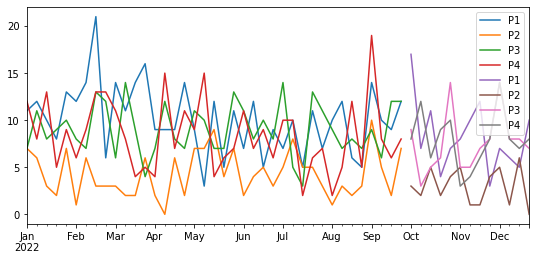

In [40]:
# Train-test dates
# ==============================================================================
end_train = '2022-09-30 23:59:00'

print(f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
print(f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  (n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data[items].loc[:end_train].plot(ax=ax, label='train')
data[items].loc[end_train:].plot(ax=ax, label='test')
ax.legend();

### ForecasterAutoreg P1

In [72]:
# Create and fit Recursive multi-step forecaster (ForecasterAutoreg)
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=123),
                    lags      = 4
             )

forecaster.fit(y=data.loc[:end_train, 'P1'], exog=data.loc[:end_train, 'Week'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4] 
Window size: 4 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: Week 
Training range: [Timestamp('2022-01-02 00:00:00'), Timestamp('2022-09-25 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-SUN 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-06-08 18:07:56 
Last fit date: 2022-06-08 18:07:56 
Skforecast version: 0.5.dev1 

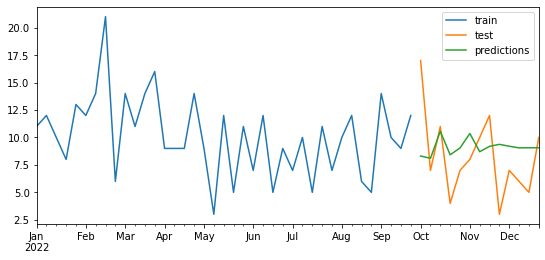

In [73]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=len(data.loc[end_train:]), exog=data.loc[end_train:, 'Week'])
predictions.head(3)

# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data['P1'].loc[:end_train].plot(ax=ax, label='train')
data['P1'].loc[end_train:].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [74]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data['P1'].loc[end_train:],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 14.450769230769229


In [75]:
# Backtesting
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data['P1'],
                                    initial_train_size = len(data['P1'].loc[:end_train]),
                                    fixed_train_size   = False,
                                    steps      = 3,
                                    exog       = data['Week'],
                                    metric     = 'mean_squared_error',
                                    refit      = True,
                                    verbose    = False
                               )

print(f"Backtest error: {metric}")

Backtest error: 17.774153846153848


In [76]:
# Grid search hyperparameter and lags
# ==============================================================================

# Regressor hyperparameters
param_grid = {'n_estimators': [10, 20],
              'max_depth': [5, 7, 10]}

# Lags used as predictors
lags_grid = [3, 4, 5]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data['P1'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 3,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = len(data['P1'].loc[:end_train]),
                        fixed_train_size   = False,
                        exog       = data['Week'],
                        return_best = False,
                        verbose     = False
               )

results_grid

Number of models compared: 18.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:01<00:00,  1.98it/s]


,lags,params,metric,max_depth,n_estimators
13,"[1, 2, 3, 4, 5]","{'max_depth': 5, 'n_estimators': 20}",17.929058,5,20
8,"[1, 2, 3, 4]","{'max_depth': 7, 'n_estimators': 10}",18.227009,7,10
11,"[1, 2, 3, 4]","{'max_depth': 10, 'n_estimators': 20}",18.253462,10,20
14,"[1, 2, 3, 4, 5]","{'max_depth': 7, 'n_estimators': 10}",18.264666,7,10
9,"[1, 2, 3, 4]","{'max_depth': 7, 'n_estimators': 20}",18.498871,7,20
6,"[1, 2, 3, 4]","{'max_depth': 5, 'n_estimators': 10}",18.499416,5,10
7,"[1, 2, 3, 4]","{'max_depth': 5, 'n_estimators': 20}",18.598506,5,20
12,"[1, 2, 3, 4, 5]","{'max_depth': 5, 'n_estimators': 10}",18.600161,5,10
10,"[1, 2, 3, 4]","{'max_depth': 10, 'n_estimators': 10}",18.813077,10,10
15,"[1, 2, 3, 4, 5]","{'max_depth': 7, 'n_estimators': 20}",19.295880,7,20


### ForecasterAutoregMultiSeries

In [77]:
# Create and fit Recursive multi-step forecaster (ForecasterAutoreg)
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                    regressor = RandomForestRegressor(random_state=123),
                    lags      = 4
             )

forecaster.fit(series=data.loc[:end_train, items], exog=data.loc[:end_train, 'Week'])
forecaster

ForecasterAutoregMultiSeries 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4] 
Window size: 4 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: Week 
Training range: [Timestamp('2022-01-02 00:00:00'), Timestamp('2022-09-25 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-SUN 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-06-08 18:08:07 
Last fit date: 2022-06-08 18:08:07 
Skforecast version: 0.5.dev1 

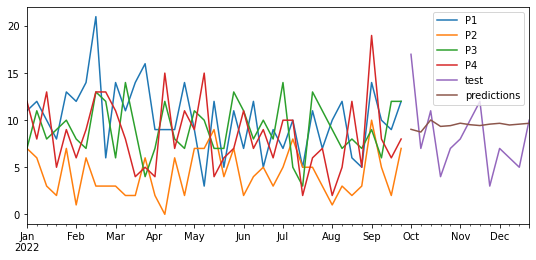

In [78]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=len(data.loc[end_train:]),
                                 level='P1',
                                 exog=data.loc[end_train:, 'Week'])
predictions.head(3)

# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.loc[:end_train, items].plot(ax=ax, label='train')
data.loc[end_train:, 'P1'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [79]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data['P1'].loc[end_train:],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 15.017638461538464


In [80]:
# Backtesting
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster_multiseries(
                                    forecaster = forecaster,
                                    series     = data[items],
                                    level      = 'P1',
                                    initial_train_size = len(data['P1'].loc[:end_train]),
                                    fixed_train_size   = False,
                                    steps      = 3,
                                    exog       = data['Week'],
                                    metric     = 'mean_squared_error',
                                    refit      = True,
                                    verbose    = False
                               )

print(f"Backtest error: {metric}")

Backtest error: 16.923238461538464


In [ ]:
# Grid search hyperparameter and lags
# ==============================================================================

# Regressor hyperparameters
param_grid = {'n_estimators': [10, 20],
              'max_depth': [5, 7, 10]}

# Lags used as predictors
lags_grid = [3, 4, 5]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data['P1'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 3,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = len(data['P1'].loc[:end_train]),
                        fixed_train_size   = False,
                        exog       = data['Week'],
                        return_best = False,
                        verbose     = False
               )

results_grid

In [85]:
# Lags used as predictors
lags_grid = [3, 4, 5]

# Regressor hyperparameters
param_grid = {'n_estimators': [10, 20],
              'max_depth': [5, 7, 10]}

param_grid = list(ParameterGrid(param_grid))

results_grid = _evaluate_grid_hyperparameters_multiseries(
                        forecaster  = forecaster,
                        series      = data[items],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 3,
                        levels_list = None,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = len(data['P1'].loc[:end_train]),
                        fixed_train_size   = False,
                        exog        = data['Week'],
                        return_best = True,
                        verbose     = False
               )

results_grid

Number of models compared: 72.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:07<00:00,  2.41s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'max_depth': 10, 'n_estimators': 20}
  Backtesting metric: 9.996191733262911
  Levels: ['P1', 'P2', 'P3', 'P4'] 
  Levels weights: {'P1': 0.25, 'P2': 0.25, 'P3': 0.25, 'P4': 0.25} 



,levels,lags,params,metric,max_depth,n_estimators
17,"[P1, P2, P3, P4]","[1, 2, 3, 4, 5]","{'max_depth': 10, 'n_estimators': 20}",9.996192,10,20
15,"[P1, P2, P3, P4]","[1, 2, 3, 4, 5]","{'max_depth': 7, 'n_estimators': 20}",10.389692,7,20
6,"[P1, P2, P3, P4]","[1, 2, 3, 4]","{'max_depth': 5, 'n_estimators': 10}",10.432557,5,10
13,"[P1, P2, P3, P4]","[1, 2, 3, 4, 5]","{'max_depth': 5, 'n_estimators': 20}",10.544319,5,20
1,"[P1, P2, P3, P4]","[1, 2, 3]","{'max_depth': 5, 'n_estimators': 20}",10.726509,5,20
7,"[P1, P2, P3, P4]","[1, 2, 3, 4]","{'max_depth': 5, 'n_estimators': 20}",10.930787,5,20
9,"[P1, P2, P3, P4]","[1, 2, 3, 4]","{'max_depth': 7, 'n_estimators': 20}",10.948408,7,20
8,"[P1, P2, P3, P4]","[1, 2, 3, 4]","{'max_depth': 7, 'n_estimators': 10}",11.008187,7,10
10,"[P1, P2, P3, P4]","[1, 2, 3, 4]","{'max_depth': 10, 'n_estimators': 10}",11.063157,10,10
11,"[P1, P2, P3, P4]","[1, 2, 3, 4]","{'max_depth': 10, 'n_estimators': 20}",11.301189,10,20


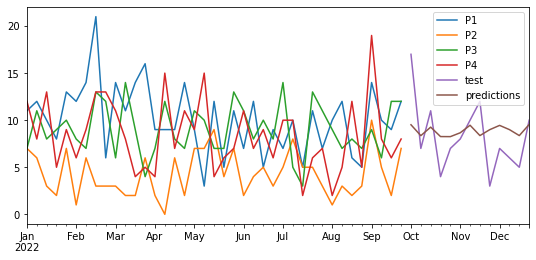

In [87]:
# Predict
# ==============================================================================
forecaster.fit(series=data.loc[:end_train, items], exog=data.loc[:end_train, 'Week'])
predictions = forecaster.predict(steps=len(data.loc[end_train:]),
                                 level='P1',
                                 exog=data.loc[end_train:, 'Week'])
predictions.head(3)

# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.loc[:end_train, items].plot(ax=ax, label='train')
data.loc[end_train:, 'P1'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();